<a href="https://colab.research.google.com/github/bmaravilla/tumor-segmentation/blob/main/tumor-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem definition: Segmentation of gliomas in MRI scans

In this jupyter notebook, we will be doing whole tumor (WT) segmentation. WT includes subregions 1, 2 and 4. 



Each pixel on image is labelled as :

- Pixel is part of a tumor area (subregions: 1, 2, 4)
- Pixel is not a part of tumor area (0)

where, 0 - no tumor, 1 - necrotic/core/ non-enhancing, 2 - edema, 4 - enhancing


**Objectivies (What will we learn here?)**
1. Setting up the env
2. Create training, validation and test ids
3. Image pre-processing
4. Performance metrics for semantic segmentation
5. Loss functions for semantic segmentation
6. Building the Unet model
7. Training the model
8. Looking at the learning curve
9. Predicting using the Unet model
10. What next? It is time to play!




## Step 1: Set up the env

Download all the packages needed.

In [163]:
# this notebook is saved in github
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib 
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from typing import Optional, Tuple

tf.config.run_functions_eagerly(True)

print(tf.__version__)

2.12.0


Because we are working on data stored in Google Cloud Storage bucket, the following steps will need to be taken:

1. Install [gcsfuse](https://colab.research.google.com/drive/19slw0Fl_kDJmaL5NIZ71bxagv5vxq55v#scrollTo=r0VPeE7kMIgW&line=3&uniqifier=1) it is a package used to mount the cloud bucket on to your local environment.
2. Authenticate your google account
3. Create a new directory to mount the storage bucket
4. Use gcsfuse to mount the storage bucket

You can browse throught the storage bucket here

In [164]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v0.41.12/gcsfuse_0.41.12_amd64.deb; \
    dpkg --install gcsfuse_0.41.12_amd64.deb; \
    apt-get update; \
    apt-get clean;

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 336 kB in 5s (74.2 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fuse is already the newest version (2.9.9-3

Now call google authentication with the following code block and allow access in the pop-up window


In [165]:
from google.colab import auth
auth.authenticate_user()

Let's set the project id and storage bucket id

In [166]:

project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Are you sure you wish to set property [core/project] to sfsu-378805?

Do you want to continue (Y/n)?  y

Updated property [core/project].


You can list using gsutil to see if we have the correct storage

In [167]:
!gsutil ls

You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


Let's make a new directory called images to mount our bucket

In [168]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


Call gcsfuse to mount the bucket


In [169]:
!gcsfuse --implicit-dirs csc-509-image-files images

2023/04/30 22:22:08.348701 Start gcsfuse/0.41.12 (Go version go1.18.4) for app "" using mount point: /content/images
2023/04/30 22:22:08.362748 Opening GCS connection...
2023/04/30 22:22:08.531859 Mounting file system "csc-509-image-files"...
2023/04/30 22:22:08.532712 File system has been successfully mounted.


In [170]:
!ls images/

Module0_UPENNGBM  Module1_BraTS  Module1_BraTS.tar.bz2	Module2_ADNI


## Step 2: Now let's create the training, validation and test ids. 


In [171]:
# Let's define the train data path.
TRAIN_DATA_PATH = Path('/content/images/Module1_BraTS/MICCAI_BraTS2020_TrainingData')

# BraTS also has "ValidationData" which has only images and no segmentation masks. So we won't be using it in this notebook. 


In [172]:
# Let's create the training, validation and test ids.

train_dir = [f.path for f in os.scandir(TRAIN_DATA_PATH) if f.is_dir()]

# We will create train, validation and test ids from the train_dir dataset


def list_to_ids(dir:str):
    """
    Will convert the dir paths to ids by parsing the paths.
    dir: string, image dir paths in BRATS
    """
    x = []
    for i in range(0,len(dir)):
        x.append(dir[i].split('/')[-1])
    return x



How to do train-test-split using sklearn: https://www.stackvidhya.com/train-test-split-using-sklearn-in-python/

In [173]:
# Now let's use the defined function

ids = list_to_ids(train_dir) 

# Split dataset to create training ids, validation ids and test ids
# Here we have selected the size of test set as 20% which is a common practice.
train_ids, test_ids = train_test_split(ids,test_size=0.2) 

# Create validation ids by further splitting the train ids, we again use 20% as size of valisation set. 
# Validation set is also referred to as tuning set. 
#doesn't read from the orginial total to the training dataset; 369 for training- 20% for validation = 295 traning imgs
#now we must use a larger % to get equal amount of validation/test datasets

train_ids, val_ids = train_test_split(train_ids,test_size=0.25) 

In [174]:
# Now looks at the number of patient ids in training, validation and test sets
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(test_ids)} patient ids in test set')
print(f'There are {len(val_ids)} patient ids in validation set')

There are 221 patient ids in training set
There are 74 patient ids in test set
There are 74 patient ids in validation set


## Step 3: Let's do some image pre-processing. You have already learnt basics of reading and visualizing nifti images, selecting slices and looking at histograms.

Here, we will look at some pre-processing steps specific to semantic segmentation. It's important to understand that the pro-processing steps could vary depending on the task at hand.


In [175]:
# Let's rewind and remember the type of images available: T1, T1CE, T2, FLAIR and corresponding masks

# We will use the read_patient_niftis module we had learnt in the previous notebook
def read_patient_niftis(patient_id: str, 
                        niftis_to_load = ['t1', 't1ce', 't2', 'flair', 'seg'], 
                        data_path = TRAIN_DATA_PATH):
  """
  Will read in the images from a single patient and return a dictionary of 
  those images with the key as the image type and the value as the nifti object. 
  patient_id: string of format '001' through '369', patient ID in BRATS
  niftis_to_load: default is list containing all the types of images that we care about; can sub in another list if desired. 
  data_path: default is DATA_PATH specified above with respect to the mounted google drive (in colab)

  """
  patient_image_dict = {}
  for image in niftis_to_load: 
    patient_image_dict[image]=nib.load(Path(data_path, f'{patient_id}', f'{patient_id}_{image}.nii.gz'))
  return patient_image_dict


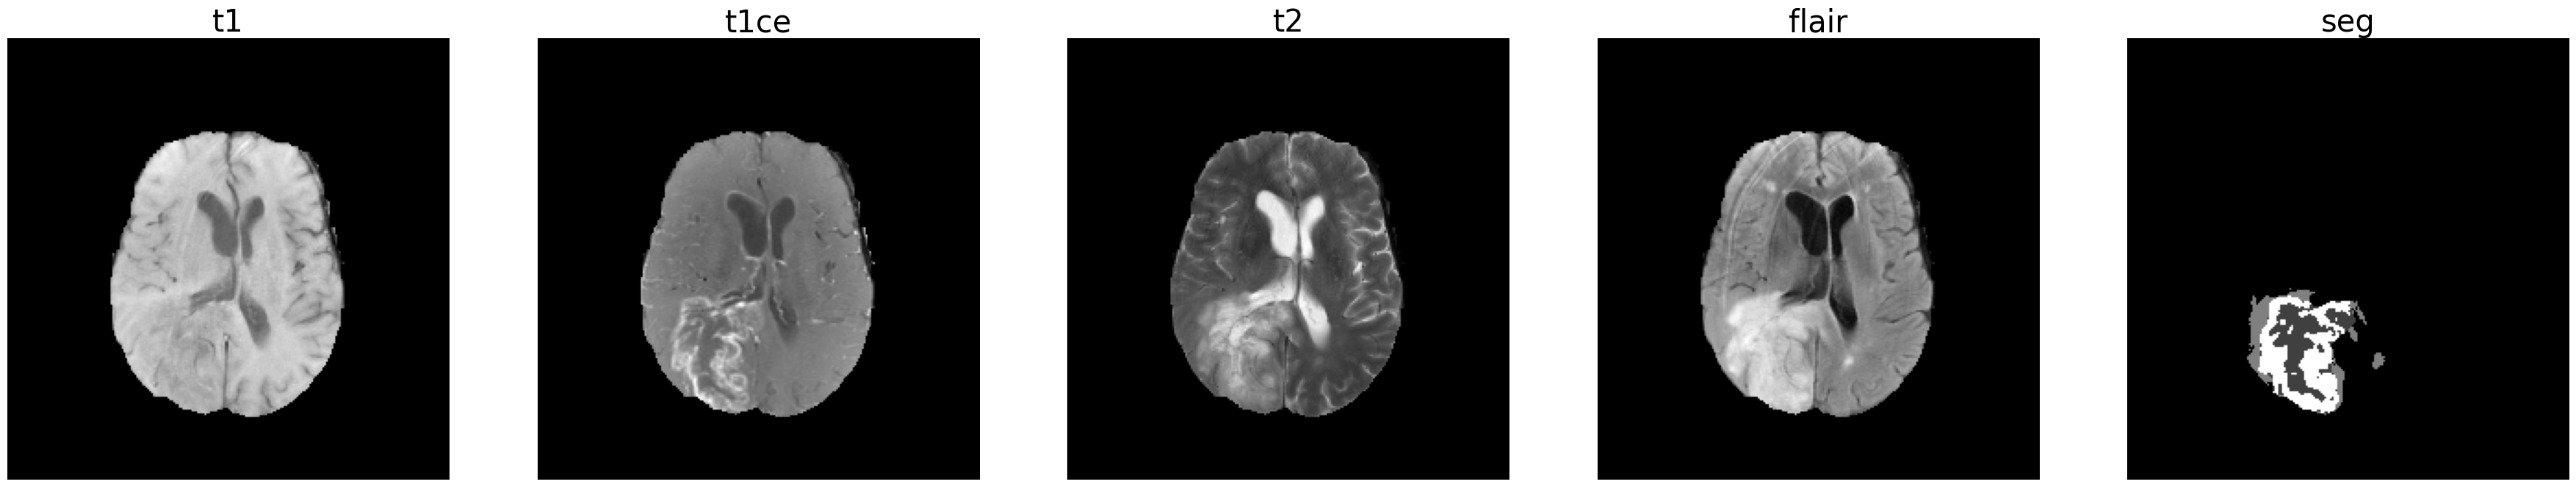

In [176]:
# Let's take a look one of the image and the corresponding segmentation mask from the training set before we proceed
pt_img_dict = read_patient_niftis(train_ids[12])

# Now lets visualize all the images side by side to get a sense of what's happening.
plt.figure(figsize=(45,30)) # specifying the overall grid size
for i, (key, value) in enumerate(pt_img_dict.items()):
    plt.subplot(1, 5, i+1)
    plt.imshow(value._dataobj[:, :, value.shape[-1]//2].T, cmap='gray') # Looks halfway through the volume and transposes the image so that its facing upward. 
    plt.axis('off')
    plt.title(key, fontsize=30)
plt.show()

A quick recap on MRI basics: https://my-ms.org/mri_basics.html

In [177]:
# For this semantic segmentation task, we will use flair images.
# And we will focus on binary or whole tumor (WT) segmentation. In order to do so we will assign the same pixel intensity (1) to the 3 tumor sub regions (1, 2, 4)

## original code
flair_img = pt_img_dict['flair'].get_fdata()
seg_img = pt_img_dict['seg'].get_fdata()

def normalize(input_image: np.ndarray = flair_img,
              input_mask: np.ndarray = seg_img,
              percentile: float = 0.001,
              eps: float = 0.0000001
              ) -> Tuple[tf.Tensor, Optional[np.ndarray]]:
    """
    Will read the input image and normalize the image between 0 and 1.
    Will read the input mask and assign pixel value 1 to all tumor subregions (1, 2, 4).
    input_image: default is t2_img, the image to be segmented.
    input_mask: default is seg_img, the ground truth or label.
    """
    img_array = np.ndarray.flatten(input_image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((input_image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    img_normalized = tf.cast(img_normalized, tf.float32) / 255
    
    mask_normalized: Optional[np.ndarray] = None
    
    if input_mask is not None:
        mask_normalized = np.zeros_like(input_mask) # Create an array of zeros with the same shape as the input mask
        mask_normalized[input_mask == 1] = 1 # Set all values of input_mask equal to 1 to 1 in mask_normalized
        mask_normalized[input_mask == 2] = 2 # Set all values of input_mask equal to 2 to 2 in mask_normalized
        mask_normalized[input_mask == 4] = 4 # Set all values of input_mask equal to 4 to 4 in mask_normalized
        
        mask_min = np.min(mask_normalized)
        mask_max = np.max(mask_normalized)
        epsilon = 1e-8
        
        if mask_max - mask_min == 0:
            mask_normalized = None # Return None for mask_normalized if the range of values is 0
        else:
            mask_normalized = (mask_normalized - mask_min) / (mask_max - mask_min + epsilon)

    return img_normalized, mask_normalized


Why is image normalizaton needed: https://arthurdouillard.com/post/normalization/

What are the different types of normalization: https://towardsdatascience.com/different-types-of-normalization-in-tensorflow-dac60396efb0

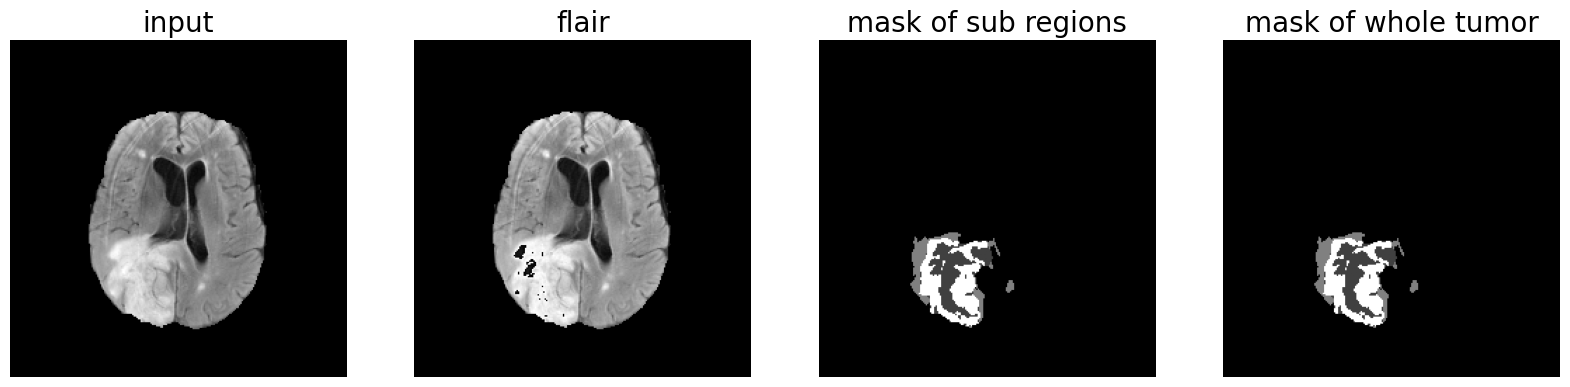

In [178]:
# Let's look at the images after normalizing
image_name = 'flair'
input_image = pt_img_dict[image_name].get_fdata()
img, mask = normalize(input_image) # t2_img, seg_img)
plt.figure(figsize=(20,30))
plt.subplot(1,4,1)
plt.imshow(tf.transpose(input_image[:,:,78]), cmap = 'gray')
plt.axis('off')
plt.title('input', fontsize=20)
plt.subplot(1,4,2)
plt.imshow(tf.transpose(img[:,:,78]), cmap = 'gray')
plt.axis('off')
plt.title(image_name, fontsize=20)
plt.subplot(1,4,3)
plt.imshow(tf.transpose(seg_img[:,:,78]), cmap = 'gray')
plt.axis('off')
plt.title('mask of sub regions', fontsize=20)
plt.subplot(1,4,4)
plt.imshow(tf.transpose(mask[:,:,78]), cmap = 'gray')
plt.axis('off')
plt.title('mask of whole tumor', fontsize=20)
plt.show()

## Step 4: Let's take a look at the performance metrics commonly used in semantic segmentation. 

The 2 common ones are 
- Dice
- Jaccard/Intersection of Union (IoU)

Both Dice and Jaccard indices are bounded between 0 and 1 with 0 indicating completely inaccurate model prediction and 1 indicating completely accurate model prediction. 

Performance metrics in image segmentation: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [179]:
# Dice
def dice_coef(y_true, y_pred):
    """
    Dice coefficient for semantic segmentation.
    
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    
    y_true: The ground truth tensor.
    y_pred: The predicted tensor
    smooth: Smoothing factor. Default is 100.    
    """
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Jaccard/IoU
def jacard_coef(y_true, y_pred):
    """
    Jaccard coefficient for semantic segmentation. Also known as the IOU loss.
    
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    y_true: The ground truth tensor.
    y_pred: The predicted tensor
    smooth: Smoothing factor. Default is 100.    
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

## Step 5: Let's take a look at loss functions for semantic segmentation. 

The default choice of loss function for segmentation and other classification tasks is Binary Cross-Entropy (BCE). Here since the metric  Dice or Jaccard Coefficient is being used to judge model performance, the loss functions that are derived from these metrics - typically in the form 1 - f(x) where f(x) is the metric in question.

Loss functions in image segmentation: https://medium.com/@junma11/loss-functions-for-medical-image-segmentation-a-taxonomy-cefa5292eec0

In [180]:
# The 2 loss functions we will look at are Dice and Jaccard loss

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)




In [215]:
def jacard_coef_weighted(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    # Define the class weights as a 1D tensor
    class_weights = K.constant([1, 1, 1, 1])

    # One-hot encode the ground truth tensor
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=4)

    intersection = K.sum(y_true_one_hot * y_pred, axis=[1, 2])
    union = K.sum(y_true_one_hot, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection

    # Apply the class-wise weights
    weighted_intersection = K.sum(intersection * class_weights, axis=-1)
    weighted_union = K.sum(union * class_weights, axis=-1)

    jaccard_coef = (weighted_intersection + K.epsilon()) / (weighted_union + K.epsilon())
    return jaccard_coef

def jacard_coef_loss_weighted(y_true, y_pred):
    return -jacard_coef_weighted(y_true, y_pred)


In [214]:
def dice_coef_weighted(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    # Define the class weights as a 1D tensor
    class_weights = K.constant([1, 1, 1, 1])

    # One-hot encode the ground truth tensor
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=4)

    intersection = K.sum(y_true_one_hot * y_pred, axis=[1, 2])
    sum_y_true_y_pred = K.sum(y_true_one_hot, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2])

    # Apply the class-wise weights
    weighted_intersection = K.sum(intersection * class_weights, axis=-1)
    weighted_sum_y_true_y_pred = K.sum(sum_y_true_y_pred * class_weights, axis=-1)

    dice_coef = (2 * weighted_intersection + K.epsilon()) / (weighted_sum_y_true_y_pred + K.epsilon())
    return dice_coef

def dice_coef_loss_weighted(y_true, y_pred):
    return -dice_coef_weighted(y_true, y_pred)


## Step 6: Now comes the most interesing bit of our learning!

We will now build the Unet model we are going to use for semantic segmentation of WT. 

What is a UNet: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

Video explaining UNet: https://www.youtube.com/watch?v=azM57JuQpQI


In [216]:
# Define the UNet model
def get_unet(input_shape=(None, None, 1),
                  num_classes=4):
    inputs = Input(shape=input_shape)
    down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
  

    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)


    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
 

    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)


    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(center)
    center = BatchNormalization()(center)


    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)


    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
 

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)


    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
 

    classify = Conv2D(1, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=[jacard_coef_loss_weighted,dice_coef_loss_weighted], metrics=['accuracy',dice_coef_weighted, jacard_coef_weighted])
    return model

model = get_unet()

Instead of constant learning rate, how to use a gradually decreasing learning rate instead: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

Lets visualize the model now!

In [206]:
# tf.keras.utils.plot_model(model, show_shapes=True)

## Step 7: Let's do some model training now.

In [185]:
# Let's define a function to create numpy arrays of training, validation and test images.

# For the sake of simplicity, we will use only the middle slice of each volume for this experiment.

X = []
Y = []
def create_numpy_array(patient_ids: str,
                       DATA_PATH,
                       slice_range: int = 1,
                       skip_slices: int = 0):
    X = []
    Y = []
    slices_to_skip = max(1, skip_slices)
    
    for i in range(len(patient_ids)):
        pt_img_dict = read_patient_niftis(patient_ids[i],
                                          niftis_to_load=['flair', 'seg'],
                                          data_path=DATA_PATH)

        images = pt_img_dict['flair']._dataobj
        masks = pt_img_dict['seg']._dataobj

        middle_slice = images.shape[-1] // 2

# Will read the middle slice and choose slices before and after the middle slice 
        for k in range(middle_slice - slice_range * slices_to_skip, middle_slice + (slice_range * slices_to_skip) + 1, max(1, skip_slices)):
            image_slice = images[:, :, k].T
            mask_slice = masks[:, :, k].T

            image, mask = normalize(image_slice, mask_slice)
            if image is not None and mask is not None:
              X.append(np.expand_dims(image, axis=2))
              Y.append(np.expand_dims(mask, axis=2))

    return np.asarray(X), np.asarray(Y)



In [186]:
# Now using the defined function, let's create train, validation and test numpy arrays.
#the first number is how many images to get from the middle slice & the second number is the spacing
X_train, Y_train = create_numpy_array(train_ids, TRAIN_DATA_PATH,2,4)
X_val, Y_val = create_numpy_array(val_ids, TRAIN_DATA_PATH, 2, 4)
X_test, Y_test = create_numpy_array(test_ids, TRAIN_DATA_PATH, 2, 4)
min_length = min(len(X_val), len(Y_val), len(X_test), len(Y_test))

X_val = X_val[:min_length]
Y_val = Y_val[:min_length]
X_test = X_test[:min_length]
Y_test = Y_test[:min_length]


Now we will read the .npy files and start our model training!We have a numpy arrays already created and saved

In [187]:
# Let's confirm the size of the training, validation and test arrays.
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')


There are 980 images in training set
There are 313 images in validation set
There are 313 images in test set


Text(0.5, 1.0, 'mask')

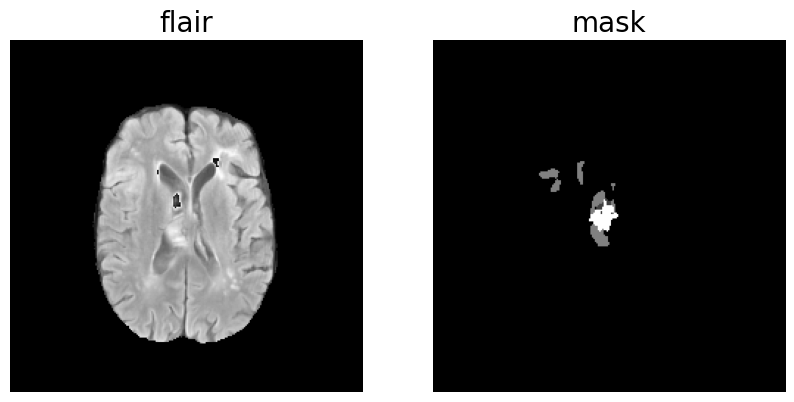

In [188]:
# Visualize the images
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(X_train[12][:,:,0], cmap = 'gray')
plt.axis('off')
plt.title(image_name, fontsize=20)
plt.subplot(1,2,2)
plt.imshow(Y_train[12][:,:,0], cmap = 'gray')
plt.axis('off')
plt.title('mask', fontsize=20)

What are tensor datasets: https://tensorflow.google.cn/guide/data

In [189]:
# Lets create tensor datasets from numpy arrays
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset_train = dataset_train.map(lambda x, y: {'image': x, 'segmentation_mask': y})
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
dataset_val = dataset_val.map(lambda x, y: {'image': x, 'segmentation_mask': y})
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
dataset_test = dataset_test.map(lambda x, y: {'image': x, 'segmentation_mask': y})

In [190]:
# Let's create image loader to resize the image
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    return input_image, input_mask

Understanding difference between batch and epoch in deep learning: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

What does AUTOTUNE do: https://www.tensorflow.org/guide/data_performance

In [191]:
# Resize the image using load_image function defined earlier
train_images = dataset_train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_images = dataset_val.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset_test.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [192]:
# Define a function to visualize an image example and its corresponding mask from the dataset.
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = 'gray')
      plt.axis('off')
    plt.show()

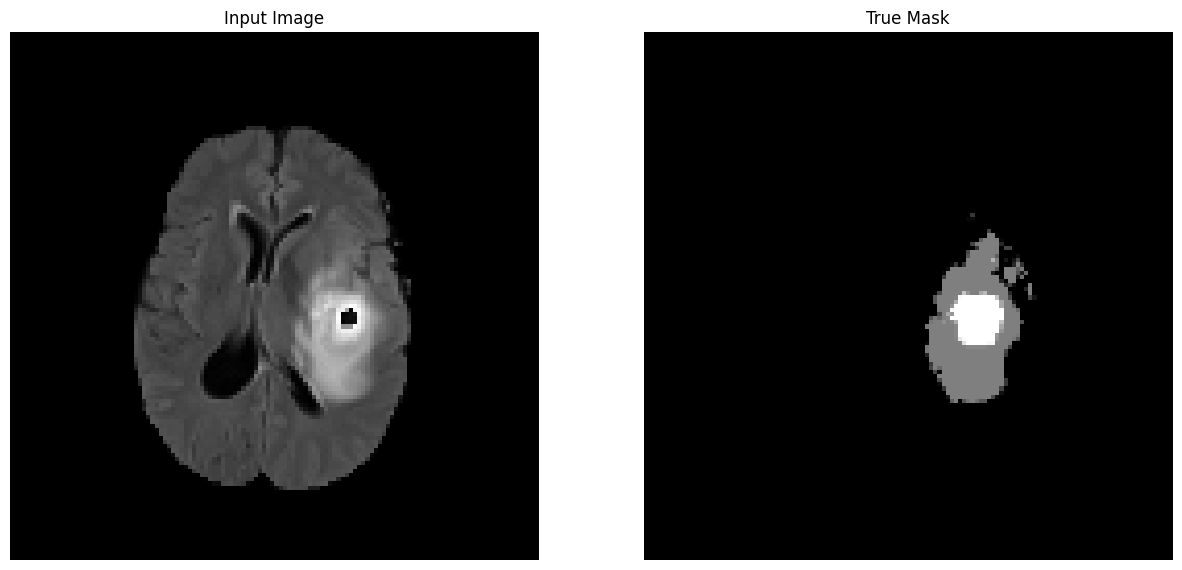

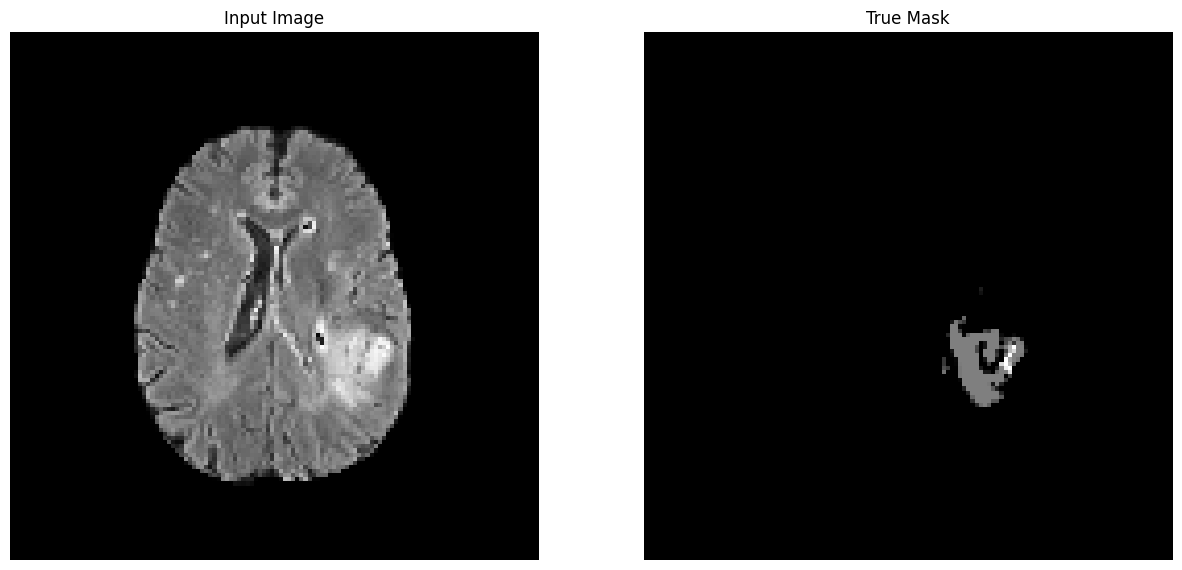

In [193]:
# Visualize an image example and its corresponding mask from the dataset batches.
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

Do you notice the change in image resolution of the above images as compared to the original images? The previous images look sharper. This is because we resized the images to 128 x 128. You can play with the load_image module and change the image size to see if that affects the model performance!

In [194]:
# Let's write a function to show the predictions
def show_predictions(dataset=None, num=4):
    if dataset:
      for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], pred_mask[0]])
    else:
      display([sample_image, sample_mask,
              model.predict(sample_image[tf.newaxis, ...])])
   

In [195]:
TRAIN_LENGTH = len(train_ids)
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [196]:
# Build the input pipeline, applying the Augmentation after batching the inputs.
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_images.batch(BATCH_SIZE)
test_batches = test_images.batch(BATCH_SIZE)

In [220]:
# Let's train the model now
smooth = 1.
EPOCHS = 10   
VAL_SUBSPLITS = 10
VALIDATION_STEPS = len(val_ids)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches)
      

Epoch 1/10
55/55 [==============================] - 23s 414ms/step - loss: -0.2495 - accuracy: 0.0165 - dice_coef_weighted: 0.3993 - jacard_coef_weighted: 0.2495 - val_loss: -0.2280 - val_accuracy: 0.2714 - val_dice_coef_weighted: 0.3713 - val_jacard_coef_weighted: 0.2280
Epoch 2/10
55/55 [==============================] - 19s 340ms/step - loss: -0.2497 - accuracy: 0.0134 - dice_coef_weighted: 0.3996 - jacard_coef_weighted: 0.2497 - val_loss: -0.2492 - val_accuracy: 0.0116 - val_dice_coef_weighted: 0.3989 - val_jacard_coef_weighted: 0.2492
Epoch 3/10
55/55 [==============================] - 19s 352ms/step - loss: -0.2498 - accuracy: 0.0119 - dice_coef_weighted: 0.3997 - jacard_coef_weighted: 0.2498 - val_loss: -0.2500 - val_accuracy: 0.0014 - val_dice_coef_weighted: 0.3999 - val_jacard_coef_weighted: 0.2500
Epoch 4/10
55/55 [==============================] - 18s 336ms/step - loss: -0.2498 - accuracy: 0.0105 - dice_coef_weighted: 0.3998 - jacard_coef_weighted: 0.2498 - val_loss: -0.2499

## Step 8: Now let's take a look at the learning curve. 

Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves.


Importance of learning curves: https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5

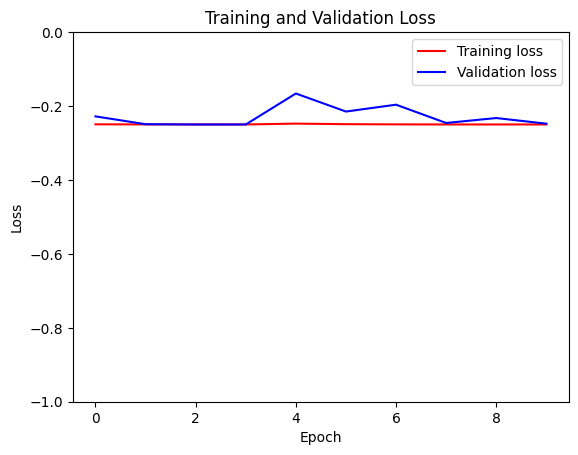

In [221]:
# Let's take a look at the learning curve now
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-1, 0])
plt.legend()
plt.show()

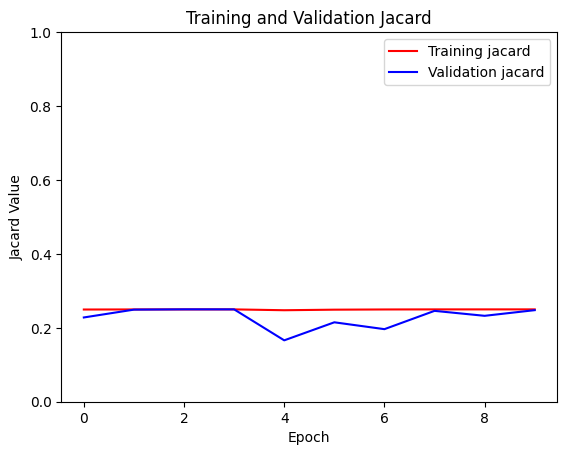

In [223]:
# Let's also look at how the dice coef changes (Since the loss function is also derived as 1 - dice_coef, you can skip looking at this)
jacard = model_history.history['jacard_coef_weighted']
val_jacard = model_history.history['val_jacard_coef_weighted']

# dice = model_history.history['dice_coef']
# val_dice = model_history.history['val_dice_coef']

plt.figure()
plt.plot(model_history.epoch, jacard, 'r', label='Training jacard')
plt.plot(model_history.epoch, val_jacard,'b', label='Validation jacard')
plt.title('Training and Validation Jacard')
plt.xlabel('Epoch')
plt.ylabel('Jacard Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

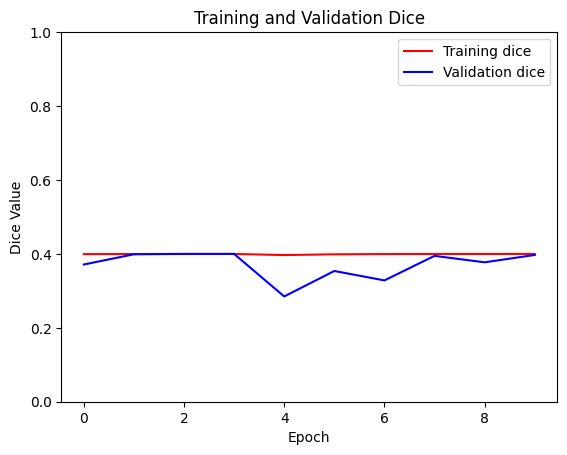

In [224]:
dice = model_history.history['dice_coef_weighted']
val_dice = model_history.history['val_dice_coef_weighted']

plt.figure()
plt.plot(model_history.epoch, dice, 'r', label='Training dice')
plt.plot(model_history.epoch, val_dice,'b', label='Validation dice')
plt.title('Training and Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

How do we choose number of epochs? Is there a way to stop training the model when it starts overfitting: https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/

Tensorflow early stopping: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

## Step 9: Now we will look at the model predictions in the validation and test sets. 

1/1 [==============================] - 0s 60ms/step


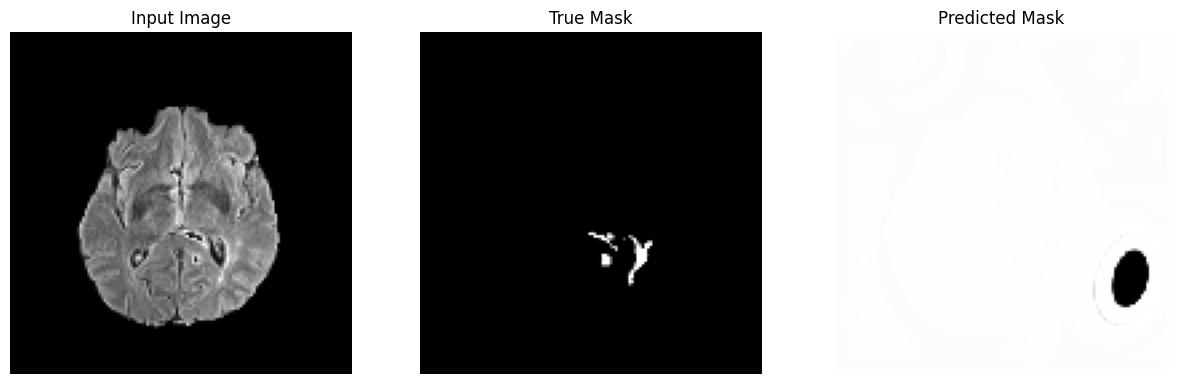

1/1 [==============================] - 0s 61ms/step


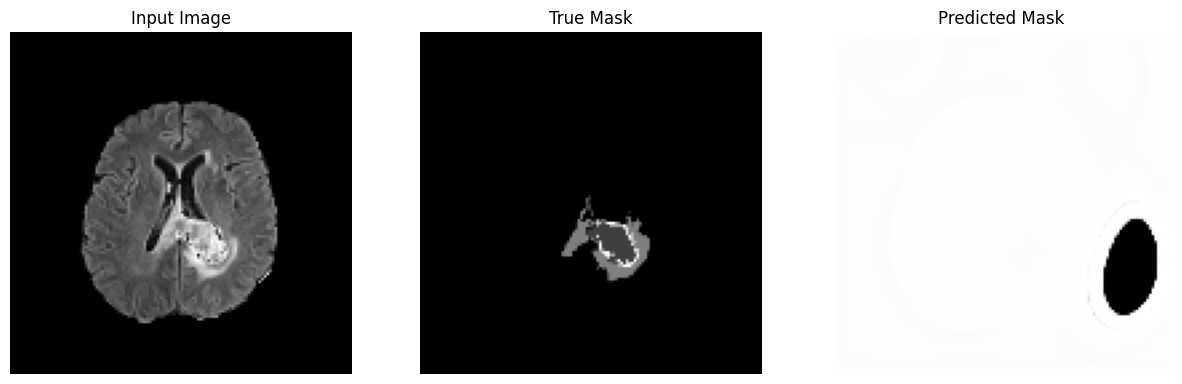

1/1 [==============================] - 0s 58ms/step


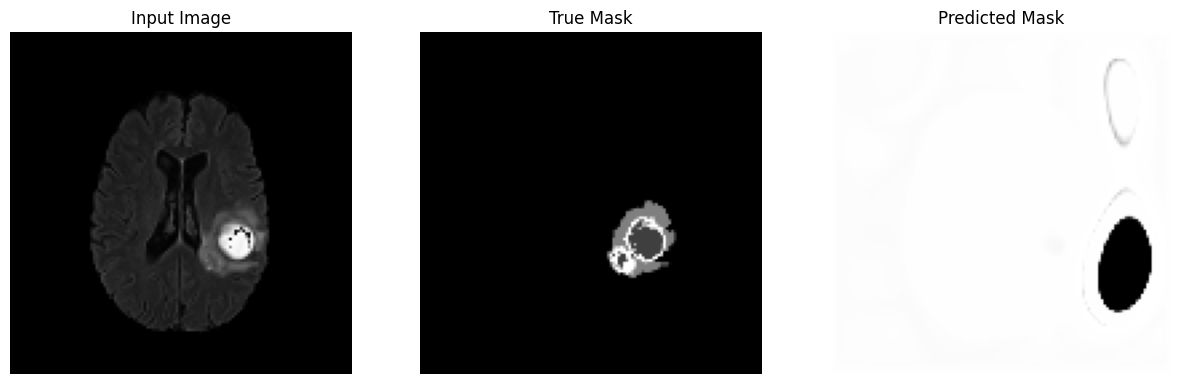

In [225]:
show_predictions(val_batches, 3)

1/1 [==============================] - 0s 86ms/step


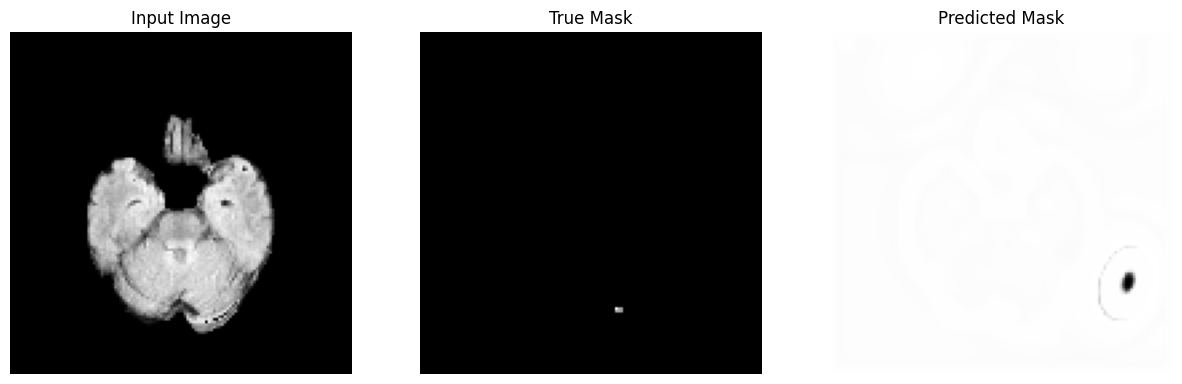

1/1 [==============================] - 0s 90ms/step


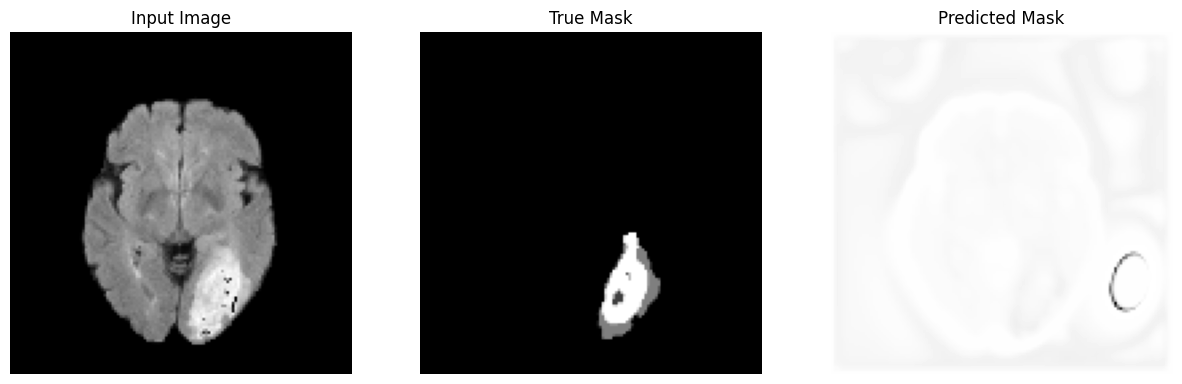

1/1 [==============================] - 0s 98ms/step


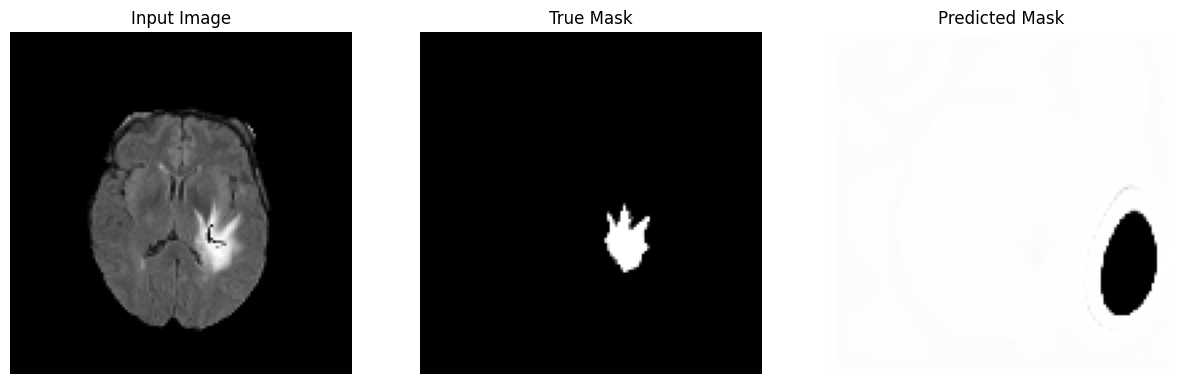

1/1 [==============================] - 0s 84ms/step


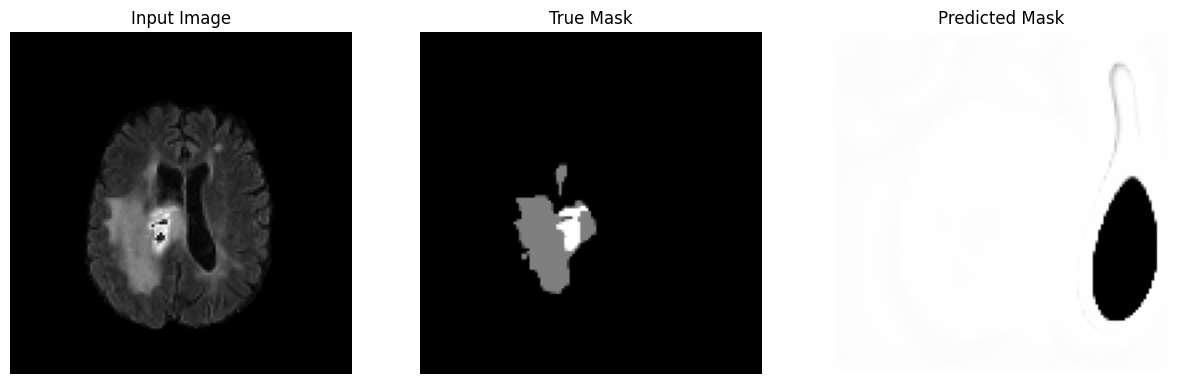

1/1 [==============================] - 0s 56ms/step


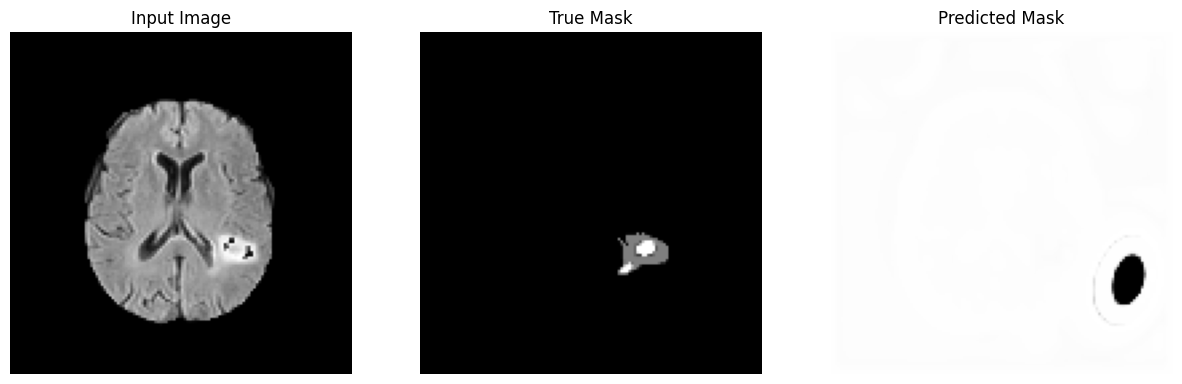

1/1 [==============================] - 0s 60ms/step


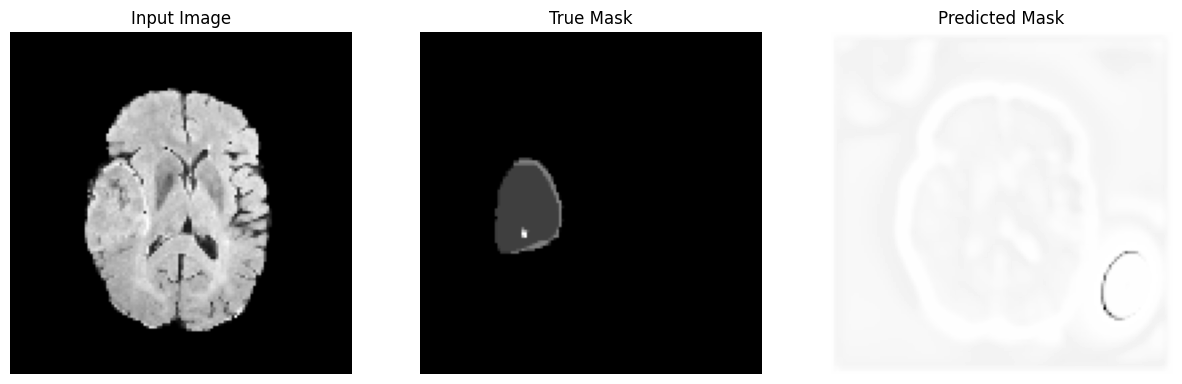

1/1 [==============================] - 0s 60ms/step


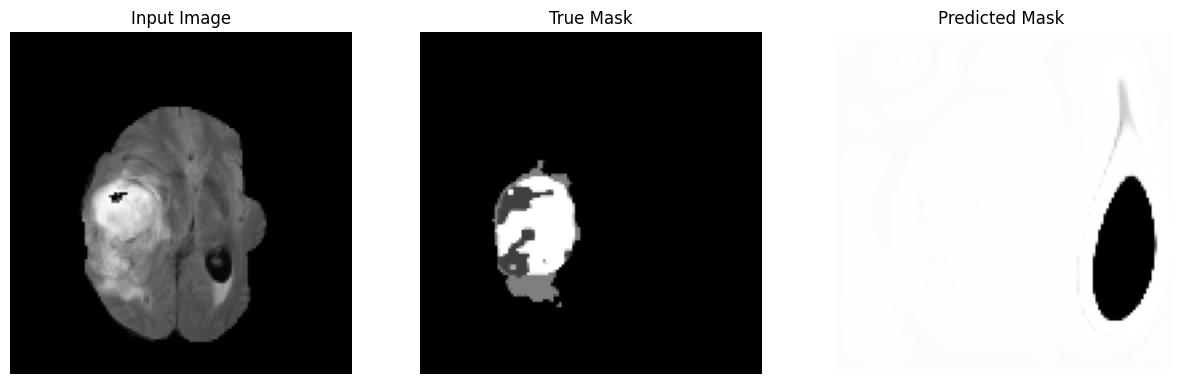

1/1 [==============================] - 0s 65ms/step


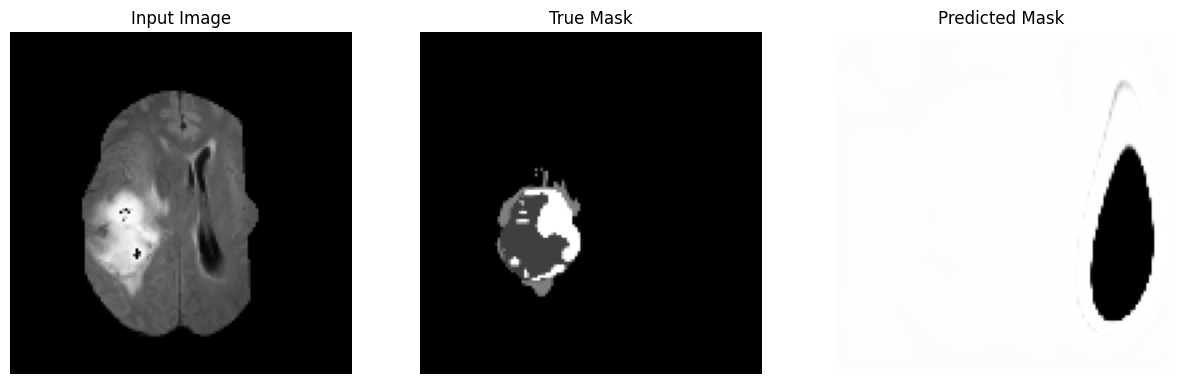

1/1 [==============================] - 0s 66ms/step


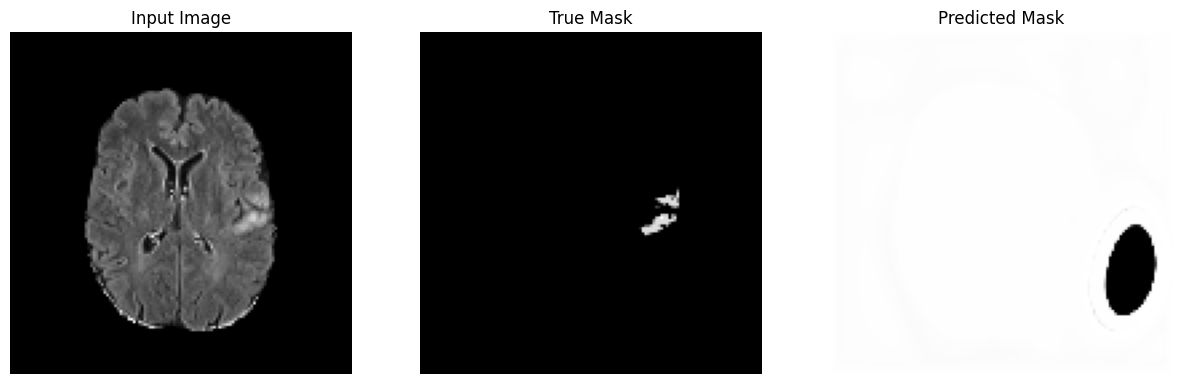

1/1 [==============================] - 0s 58ms/step


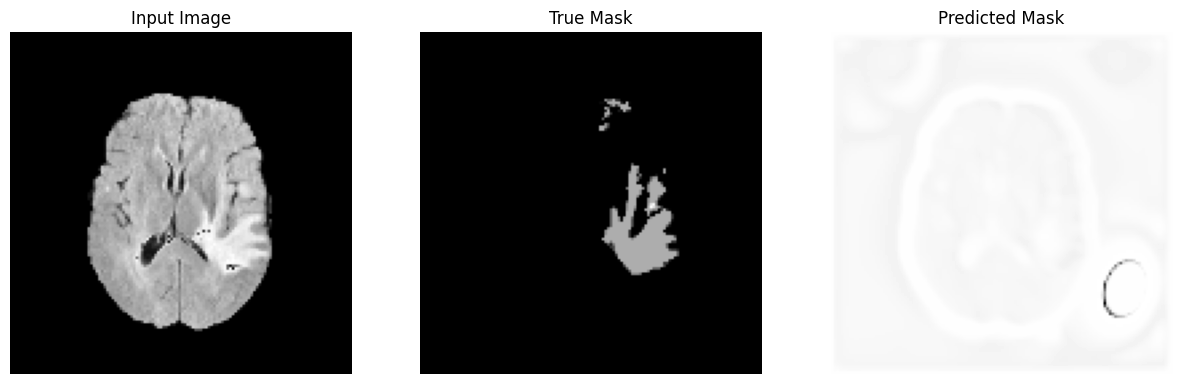

1/1 [==============================] - 0s 56ms/step


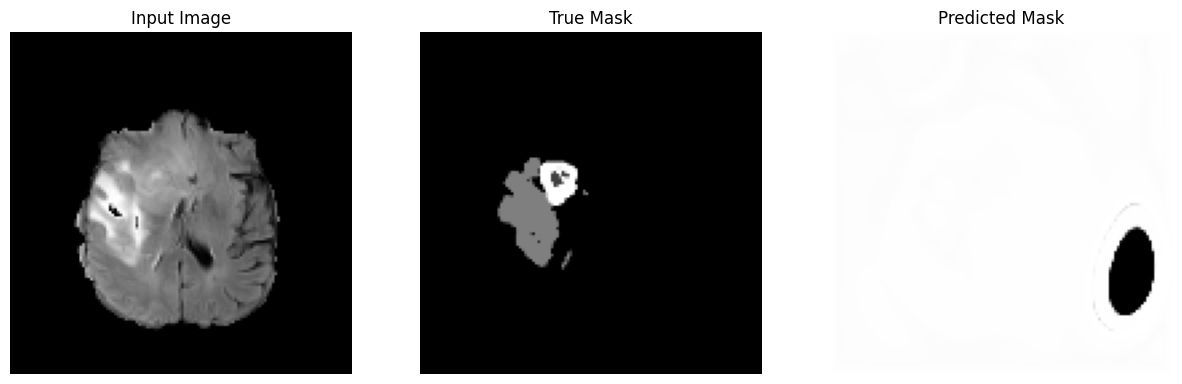

1/1 [==============================] - 0s 57ms/step


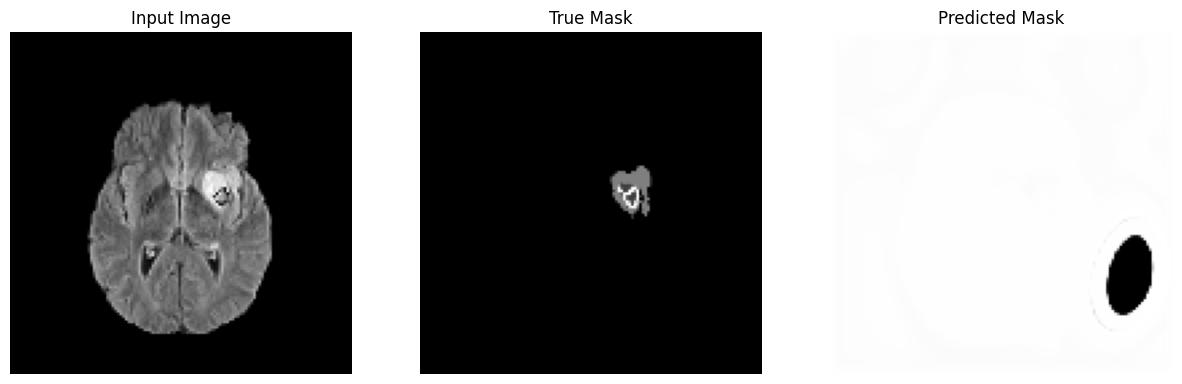

1/1 [==============================] - 0s 66ms/step


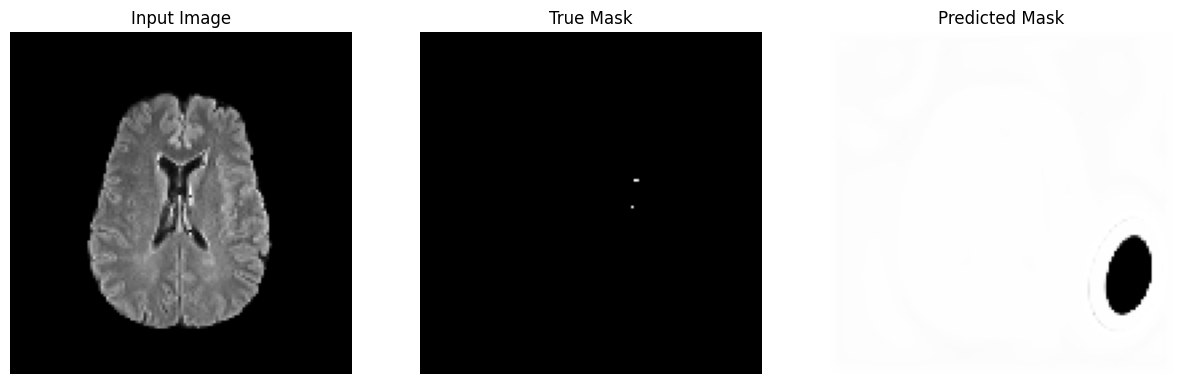

In [226]:
show_predictions(test_batches, 13)

1/1 [==============================] - 0s 63ms/step


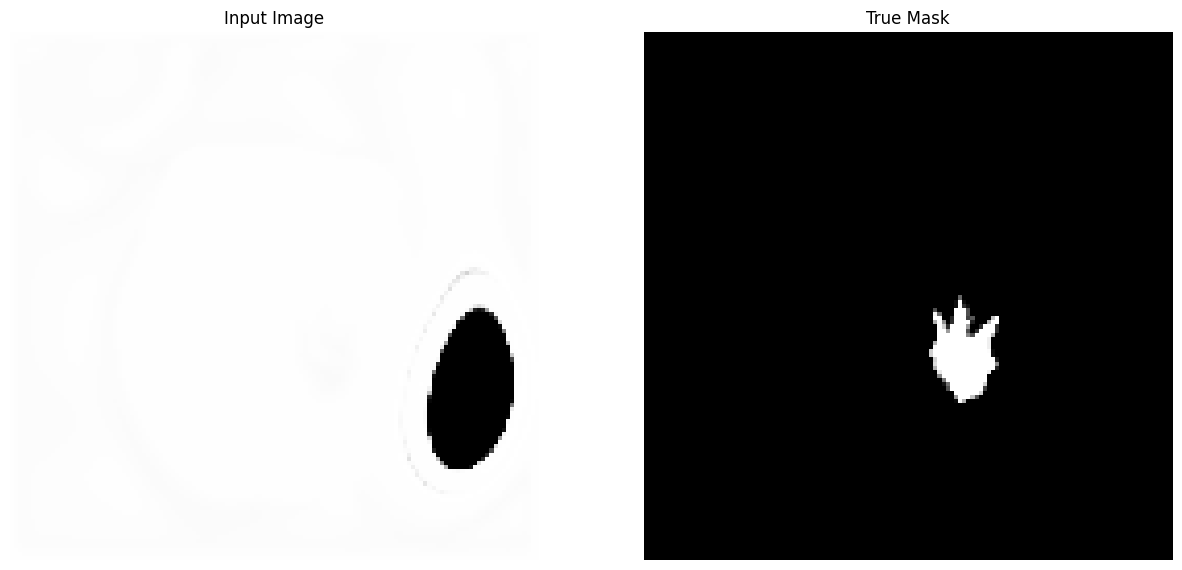

(<matplotlib.image.AxesImage at 0x7f6b079fe650>,
 Text(0.5, 1.0, 'Overlayed Mask'))

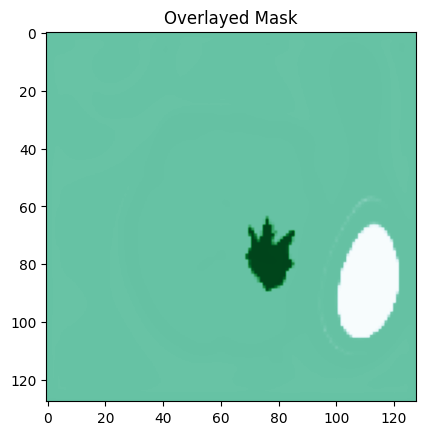

In [227]:
for image, mask in test_batches.take(3):
  predicted_mask = model.predict(image)[0]
  true_mask = mask[0].numpy()
  overlay = cv2.add(predicted_mask, true_mask)

display([predicted_mask, true_mask])
plt.imshow(overlay, 'BuGn'), plt.title ('Overlayed Mask')

## Step 10: What next? There are so many things you could do here. So it is now time to play!

As a home-work or self learning task, you can try a variety of experiments to understand how the model performance is affected. 

You can also do some of this as your term project.  

Try to think about what could improve the model performance?
1. Will increasing the size of training set help? We are just using 1 slice per volume, will using more slices help?
2. Will changing the hyper-parameters like optimizer, learning rate, loss function, epochs, batch size improve the model performance? For ex. you have already learnt about BCE loss function. What will happen if you change the loss function?
3. Will changing the type of image help? Is T2 the right image for the model? Should I try with T1/T1CE/FLAIR?
4. Can I use 2/3 channel input image instead of single channel? Can have 3 different images in the 3 channels, say T1, T2 and FLAIR? Will that give the model more information to perform better?
5. How is the learning curve for this trained model? Is it underfitting? Does it need more training? How much training is enough and when should I stop?
6. Can I modify the Unet model to improve the performance? What can I change? 

And there is so much more! This is just a starting point. Model training and hyper-parameter tuning is the time consuming of any deep learning project. 
 
Next what?
In this example we learnt a binary or 2 class segmentation problem. It can be extended to a multi-class problem. 

Another fun task to do would be to try a multi-class segmentation where you can try and predict the different sub-regions of the tumors. What will you need yo modify in the current code to change it to a multi-class problem?

Are there ways to automate hyper-parameter tuning: https://neptune.ai/blog/hyperparameter-tuning-in-python-complete-guide




In [ ]:
# # Some additional functions defined for model training

# # Let's look at an example of how we modify the create_numpy_array module if we want to have a multi channel image (for ex. T1, T2, FLAIR)


# X = []
# Y = []

# def create_numpy_array(patient_ids:str,
#                        DATA_PATH):
#     X = []
#     Y = []
    
#     for i in range(len(patient_ids)):
#         pt_img_dict = read_patient_niftis(patient_ids[i],
#                                           niftis_to_load = ['t1', 't2', 'flair', 'seg'], 
#                                           data_path = DATA_PATH)
        
#         images = []
       
#         for j, (key, value) in enumerate(pt_img_dict.items()):
#             images.append(value._dataobj[:, :, value.shape[-1]//2].T)
        
#         images_3 = cv2.merge((images[0],images[1],images[2]))
#         image, mask = normalize(images_3, images[3])
#         X.append(image)
#         Y.append(expand_dims(mask, axis=2))   

#     return np.asarray(X), np.asarray(Y)



In [ ]:
# # Create training, validation and test numpy arrays using bove defined function
# X_train, Y_train = create_numpy_array(train_ids, TRAIN_DATA_PATH)
# X_val, Y_val = create_numpy_array(val_ids, TRAIN_DATA_PATH)
# X_test, Y_test = create_numpy_array(test_ids, TRAIN_DATA_PATH)

In [ ]:
# # Let's look at an example of how we change the numpy array if we want to have a multiple slices per volume


# X = []
# Y = []

# def create_numpy_array(patient_ids:str,
#                        DATA_PATH):
#     X = []
#     Y = []
    
#     for i in range(len(patient_ids)):
#         pt_img_dict = read_patient_niftis(patient_ids[i],
#                                           niftis_to_load = ['t2', 'seg'], 
#                                           data_path = DATA_PATH)
        
#         images = []
#         # Let's say you want 5 slices sampled every 10 slices centered around middle slice
#         n = [-20, -10, 0, 10, 20]
#         count = -1
#         for k in n:
#             for j, (key, value) in enumerate(pt_img_dict.items()):
#                 images.append(value._dataobj[:, :, ((value.shape[-1]//2) + k)].T)
#             count = count + 1
               
#             image, mask = normalize(images[count*2], images[(count*2)+1])
#             X.append(expand_dims(image, axis=2))
#             Y.append(expand_dims(mask, axis=2))   

#     return np.asarray(X), np.asarray(Y)

In [ ]:
# # Create training, validation and test numpy arrays using bove defined function
# X_train, Y_train = create_numpy_array(train_ids, TRAIN_DATA_PATH)
# X_val, Y_val = create_numpy_array(val_ids, TRAIN_DATA_PATH)
# X_test, Y_test = create_numpy_array(test_ids, TRAIN_DATA_PATH)